In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')

In [ ]:
self.trainSentences = readfile("/content/train.txt")
self.devSentences = readfile("/content/dev.txt")
self.testSentences = readfile("/content/test.txt")

In [ ]:
"""Load packages"""

import numpy as np

from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate

from keras.utils.vis_utils  import plot_model
from keras.initializers import RandomUniform
from tensorflow.keras.optimizers import SGD, Nadam

# From: https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs

import numpy as np
import random
from keras.preprocessing.sequence import pad_sequences


def readfile(filename, *, encoding="UTF8"):
    '''
    read file
    return format :
    [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ]
    '''
    with open(filename, mode='rt', encoding=encoding) as f:
        sentences = []
        sentence = []
        for line in f:
            if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
                if len(sentence) > 0:
                    sentences.append(sentence)
                    sentence = []
                continue
            splits = line.split(' ')
            sentence.append([splits[0], splits[-1]])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences


# define casing s.t. NN can use case information to learn patterns
def getCasing(word, caseLookup):
    casing = 'other'

    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1

    digitFraction = numDigits / float(len(word))

    if word.isdigit():  # Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower():  # All lower case
        casing = 'allLower'
    elif word.isupper():  # All upper case
        casing = 'allUpper'
    elif word[0].isupper():  # is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'

    return caseLookup[casing]


# return batches ordered by words in sentence
def createEqualBatches(data):
    
    
    # num_words = []
    # for i in data:
    #     num_words.append(len(i[0]))
    # num_words = set(num_words)
    
    n_batches = 100
    batch_size = len(data) // n_batches
    num_words = [batch_size*(i+1) for i in range(0, n_batches)]
    
    batches = []
    batch_len = []
    z = 0
    start = 0
    for end in num_words:
        # print("start", start)
        for batch in data[start:end]:
            # if len(batch[0]) == i:  # if sentence has i words
            batches.append(batch)
            z += 1
        batch_len.append(z)
        start = end

    return batches, batch_len

def createBatches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches = []
    batch_len = []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches,batch_len


# returns matrix with 1 entry = list of 4 elements:
# word indices, case indices, character indices, label indices
def createMatrices(sentences, word2Idx, label2Idx, case2Idx, char2Idx):
    unknownIdx = word2Idx['UNKNOWN_TOKEN']
    paddingIdx = word2Idx['PADDING_TOKEN']

    dataset = []

    wordCount = 0
    unknownWordCount = 0

    for sentence in sentences:
        wordIndices = []
        caseIndices = []
        charIndices = []
        labelIndices = []

        for word, char, label in sentence:
            wordCount += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = unknownIdx
                unknownWordCount += 1
            charIdx = []
            for x in char:
                charIdx.append(char2Idx[x])
            # Get the label and map to int
            wordIndices.append(wordIdx)
            caseIndices.append(getCasing(word, case2Idx))
            charIndices.append(charIdx)
            labelIndices.append(label2Idx[label])

        dataset.append([wordIndices, caseIndices, charIndices, labelIndices])

    return dataset


def iterate_minibatches(dataset, batch_len):
    start = 0
    for i in batch_len:
        tokens = []
        caseing = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t, c, ch, l = dt
            l = np.expand_dims(l, -1)
            tokens.append(t)
            caseing.append(c)
            char.append(ch)
            labels.append(l)
        
        yield np.asarray(labels), np.asarray(tokens), np.asarray(caseing), np.asarray(char)        


# returns data with character information in format
# [['EU', ['E', 'U'], 'B-ORG\n'], ...]
def addCharInformation(Sentences):
    for i, sentence in enumerate(Sentences):
        for j, data in enumerate(sentence):
            chars = [c for c in data[0]]
            Sentences[i][j] = [data[0], chars, data[1]]
    return Sentences


# 0-pads all words
def padding(Sentences):
    maxlen = 52
    for sentence in Sentences:
        char = sentence[2]
        for x in char:
            maxlen = max(maxlen, len(x))
    for i, sentence in enumerate(Sentences):
        Sentences[i][2] = pad_sequences(Sentences[i][2], 52, padding='post')
    return Sentences



# From: https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs

import numpy as np


# Method to compute the accuracy. Call predict_labels to get the labels for the dataset
def compute_f1(predictions, correct, idx2Label):
    label_pred = []
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])

    label_correct = []
    for sentence in correct:
        label_correct.append([idx2Label[element] for element in sentence])

    # print("predictions ", len(label_pred))
    # print("correct labels ", len(label_correct))

    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)

    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);

    return prec, rec, f1


def compute_precision(guessed_sentences, correct_sentences):
    assert (len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0

    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert (len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'B':  # a new chunk starts
                count += 1

                if guessed[idx] == correct[idx]:  # first prediction correct
                    idx += 1
                    correctlyFound = True

                    while idx < len(guessed) and guessed[idx][0] == 'I':  # scan entire chunk
                        if guessed[idx] != correct[idx]:
                            correctlyFound = False 

                        idx += 1

                    if idx < len(guessed):
                        if correct[idx][0] == 'I':  # chunk in correct was longer
                            correctlyFound = False

                    if correctlyFound:
                        correctCount += 1
                else:
                    idx += 1
            else:
                idx += 1

    precision = 0
    if count > 0:
        precision = float(correctCount) / count

    return precision



In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip && mv ./glove.6B.50d.txt /content/drive/MyDrive/ColabNotebooks

--2022-02-03 11:49:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 11:49:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 11:49:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
"""Initialise class"""

class CNN_BLSTM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def loadData(self):
        """Load data and add character information"""
        self.trainSentences = readfile("/content/train.txt")
        self.devSentences = readfile("/content/dev.txt")
        self.testSentences = readfile("/content/test.txt")

    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}

        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels   
                    labelSet.add(label)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # read GLoVE word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        fEmbeddings = open("./glove.6B.50d.txt", encoding="utf-8")

        # loop through each word in embeddings
        for line in fEmbeddings:
            split = line.strip().split(" ")
            word = split[0]  # embedding word entry

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                self.wordEmbeddings.append(vector)

            if split[0].lower() in words:
                vector = np.array([float(num) for num in split[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))

        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            pred = model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)

        # concat & BLSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Default training"""

        self.f1_test_history = []
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch       
                self.model.train_on_batch([tokens, casing,char], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")
            
        # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")

    def writeToFile(self):
        """Write output to file"""

        # .txt file format
        # [epoch  ]
        # [f1_test]
        # [f1_dev ]
        
        output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])

        fileName = self.modelName + ".txt"
        with open(fileName,'wb') as f:
            for line in output:
                np.savetxt(f, line, fmt='%.5f')
                
        print("Model performance written to file.")

    print("Class initialised.")

Class initialised.


In [ ]:
"""Set parameters"""

EPOCHS = 30               # paper: 80
DROPOUT = 0.5             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 200     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended


In [ ]:
"""Construct and run model"""

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.1676
f1 dev  0.1899 

Epoch 1/30
f1 test  0.544


# Plot learning curve

In [ ]:
import matplotlib.pyplot as plt

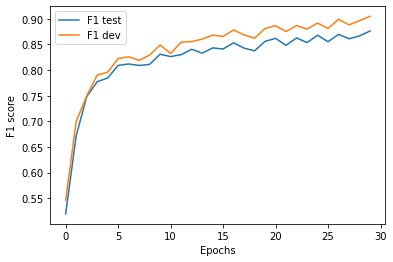

In [ ]:
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Label distribution

In [ ]:
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()

category_count = {"B-ORG\n": 0, "I-ORG\n":0, "B-MISC\n": 0, "I-MISC\n":0, "B-LOC\n": 0, "I-LOC\n": 0, "B-PER\n": 0, "I-PER\n": 0, "O\n": 0}
total_count = 0

for sentence in cnn_blstm.trainSentences:
    for word in sentence:
        if word[1] in category_count.keys():
            category_count[word[1]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))            

B-ORG: 3.1%
I-ORG: 1.82%
B-MISC: 1.69%
I-MISC: 0.57%
B-LOC: 3.51%
I-LOC: 0.57%
B-PER: 3.24%
I-PER: 2.22%
O: 83.28%
